# SYSID - Trabalho (ML - MISO.LM)

Alunos: 

Pedro Henrique Cardoso Paulo</br>
Felipe da Costa Pereira

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import os
import pickle
import copy
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#Modelos
from tpot import TPOTRegressor
from hpsklearn import HyperoptEstimator
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe

#Busca de modelos
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

# Scores
from sklearn.metrics import r2_score

# Disabling warnings
import warnings
from sklearn.exceptions import DataConversionWarning

#Definindo random_state
rs = 85

In [2]:
#%pip install ..
from sklearn_sid.regressors.sklearn import SYSIDRegressor

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [3]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/gits/sklearn-sid/Volve-Dataset/data/volve_compiled.pkl


In [4]:
for wellp in data['OP'].keys():
    print(wellp)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Visualizando dados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


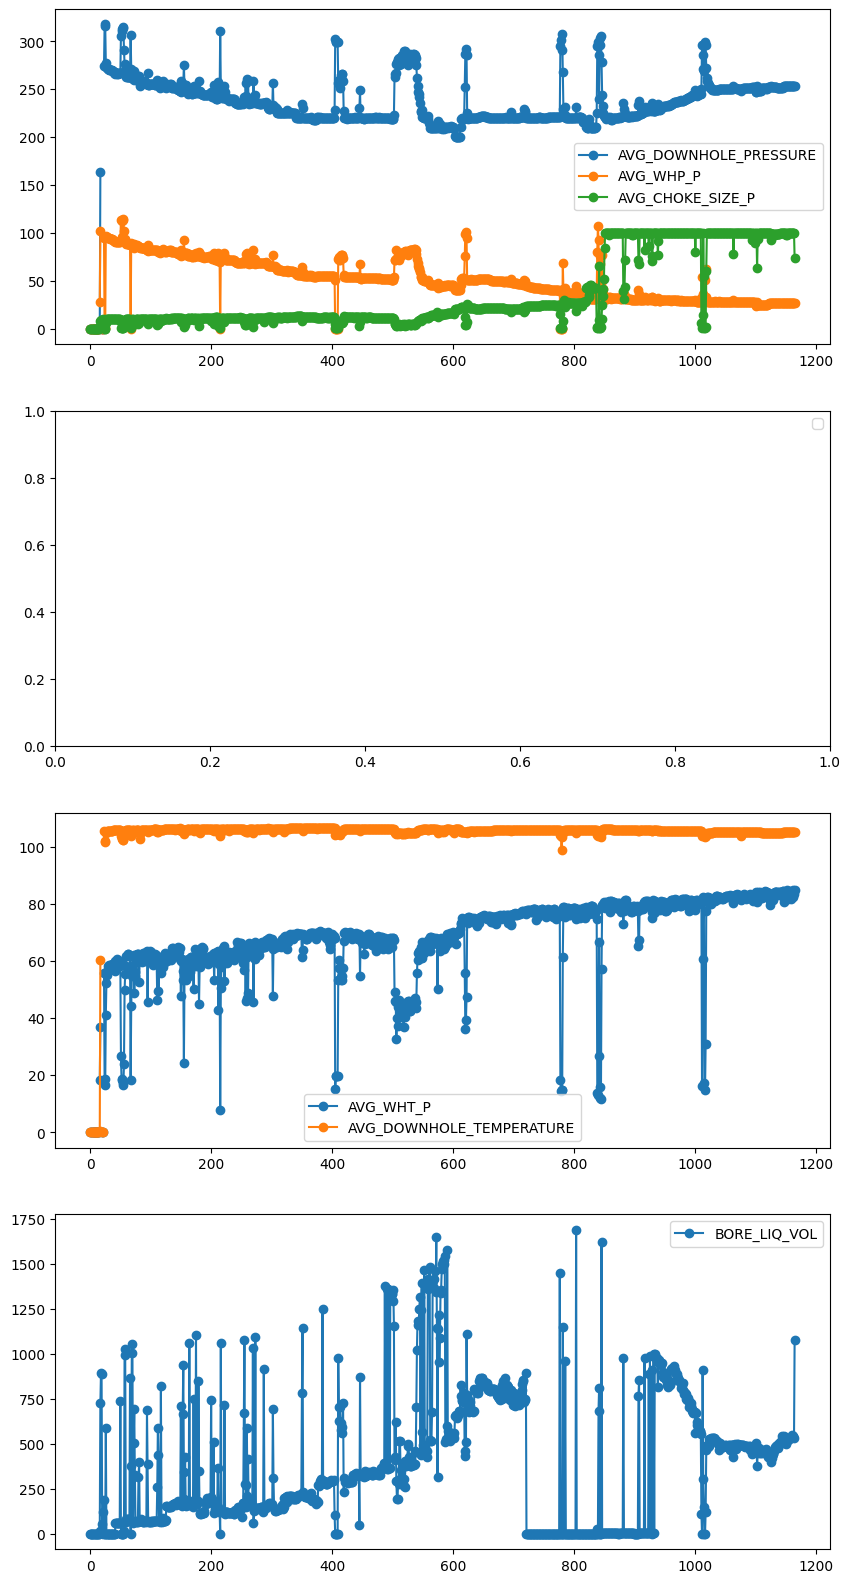

In [16]:
case = "15/9-F-11"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        'AVG_WHT_P',
        'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [6]:
data_case = data_case.iloc[28:,:]
#data_case = data_case[data_case['AVG_DOWNHOLE_PRESSURE']>0]
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [7]:
p_train = 0.7 #70% treino

### 1.2 - Separando os conjuntos

In [8]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[:,:]
y_te = y[:,:]

In [9]:
print(
    X1_tr.shape,
    X1_te.shape
)

(502, 5) (718, 5)


### 1.3 - Removendo a escala 

In [10]:
X_scale = MinMaxScaler()
y_scale = MinMaxScaler()
X_tr = X_scale.fit_transform(X1_tr)
X_te = X_scale.transform(X1_te)
y_tr = y_scale.fit_transform(y_tr)
y_te = y_scale.transform(y_te)

## Passo 2 - Declarando os modelos 

In [11]:
models = []

### 2.1 - ARMAX (sysidentpy)

### 2.2 - NARMAX (sysidentpy)

### 2.3 - Modelos de ML (sklearn)

#### 2.3.1 - Modelos

In [12]:
kfolds = 5
niters = 10
rkf = RepeatedKFold(n_splits=kfolds, n_repeats=niters, random_state=71)

In [18]:
models = [
    ('TPOT', SYSIDRegressor(
            nX=6, ny=6,
            estimator=TPOTRegressor(generations=5, population_size=50, cv=rkf, scoring='r2', verbosity=2, random_state=rs, n_jobs=1))),
    ('HOptSkl', SYSIDRegressor(
            nX=6, ny=6,
            estimator=HyperoptEstimator(regressor=any_regressor('reg'), preprocessing=any_preprocessing('pre'), algo=tpe.suggest, seed=rs, verbose=True)))
]

In [16]:
n_models = len(models)

results = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
    'PARS':[]
}

order_progression = {
    'MODEL':[],
    'ORDER':[],
    'R2 TRAIN OSA':[],
    'R2 TEST OSA':[],
    'R2 TRAIN FS':[],
    'R2 TEST FS':[],
    'MODEL OBJ':[],
}

In [19]:
for model in models:
    print(model[0])

TPOT
HOptSkl


Starting evaluation of model: TPOT
    Trying order: 2


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8021588039819929

Generation 2 - Current best internal CV score: 0.8021588039819929

Generation 3 - Current best internal CV score: 0.8021588039819929

Generation 4 - Current best internal CV score: 0.804426568605125

Generation 5 - Current best internal CV score: 0.804426568605125

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.2, min_samples_leaf=2, min_samples_split=9, n_estimators=100)


TypeError: cannot pickle '_contextvars.Context' object

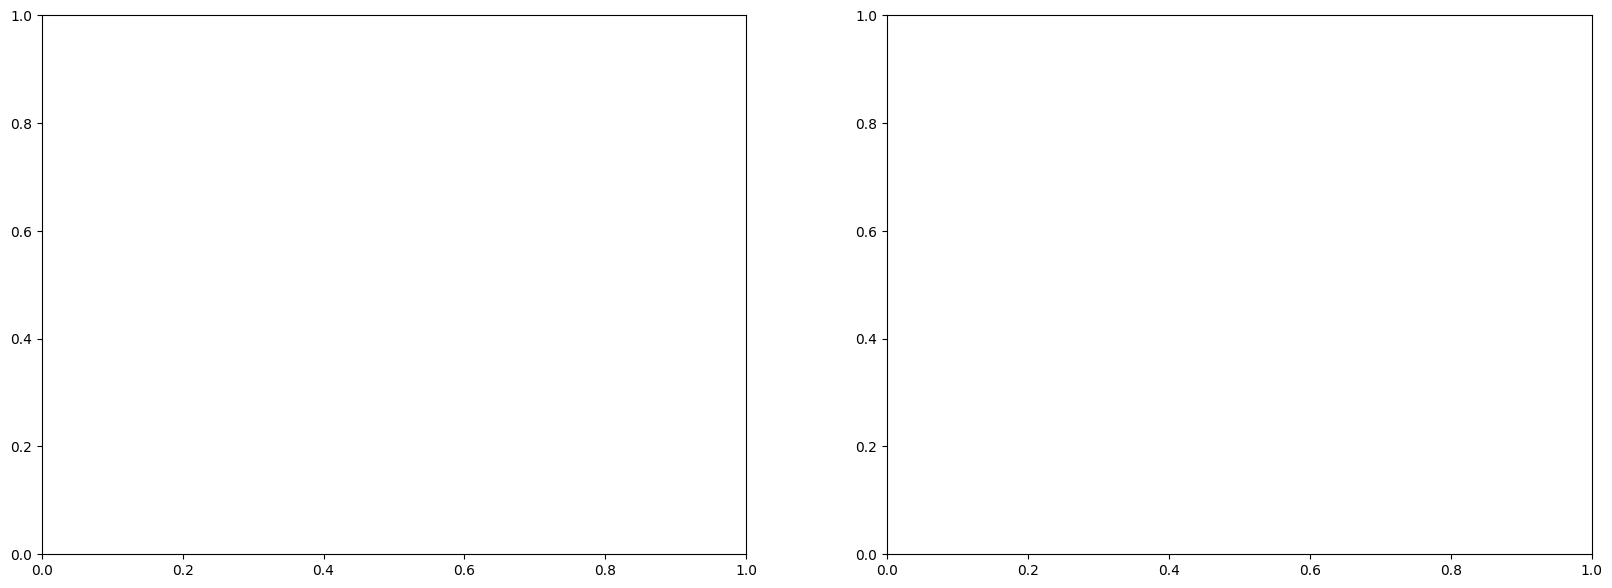

In [21]:

#fig, axs = plt.subplots(ncols=2, nrows=n_models, figsize=(25,n_models*7))
orders = range(2,21)
prefix = 'MISO.W1.AUTOML'
#Loop principal, iterando sobre as listas
for model in models[:]:
    
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,7))

    model_name, sidmodel = model

    print('Starting evaluation of model: {}'.format(model_name))
    
    t0 = datetime.now()

    best_r2_tr_fs = 1e6
    best_r2_te_fs = 1e6
    best_r2_tr_osa = 1e6
    best_r2_te_osa = 1e6
    best_order = 0
    best_model = sidmodel
    
    for order in orders:
        print(f'    Trying order: {order}')
        if hasattr(sidmodel, 'nX'): # is from our package
            sidmodel.nX = order
            sidmodel.ny = order

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sidmodel.fit(X=X1_tr, y=y_tr)
        r2_tr_osa = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr, steps_ahead=1))
        r2_te_osa = r2_score(y_te, sidmodel.predict(X1_te, y=y_te, steps_ahead=1))
        try:
            r2_tr_fs = r2_score(y_tr, sidmodel.predict(X1_tr, y=y_tr))
            r2_te_fs = r2_score(y_te, sidmodel.predict(X1_te, y=y_te))
        except ValueError:
            r2_tr_fs = 1e290
            r2_te_fs = 1e290
        if np.abs(r2_tr_fs - 1) < np.abs(best_r2_tr_fs - 1):
            best_r2_tr_fs = r2_tr_fs
            best_r2_te_fs = r2_te_fs
            best_r2_tr_osa = r2_tr_osa
            best_r2_te_osa = r2_te_osa
            best_order = order
            best_model = copy.deepcopy(sidmodel)
        order_progression['MODEL'].append(model_name)
        order_progression['ORDER'].append(order)
        order_progression['R2 TRAIN OSA'].append(r2_tr_osa)
        order_progression['R2 TEST OSA'].append(r2_te_osa)
        order_progression['R2 TRAIN FS'].append(r2_tr_fs)
        order_progression['R2 TEST FS'].append(r2_te_fs)
        order_progression['MODEL OBJ'].append(copy.deepcopy(sidmodel))
        print('        R2 score OSA (Train):', r2_tr_osa)
        print('        R2 score OSA (Test):', r2_te_osa)
        print('        R2 score FS (Train):', r2_tr_fs)
        print('        R2 score FS (Test):', r2_te_fs)
    print()
    print('    Tempo de execução: {}'.format(datetime.now() - t0))
    print('    Best Order:', best_order)
    print('    R2 score OSA (Train):', best_r2_tr_osa)
    print('    R2 score OSA (Test):', best_r2_te_osa)
    print('    R2 score FS (Train):', best_r2_tr_fs)
    print('    R2 score FS (Test):', best_r2_te_fs)

    hist = ax[0].plot(y_tr, label='Train')
    hist = ax[0].plot(best_model.predict(X1_tr, y=y_tr), label='Model') 
    ax[0].set_title(f'Train fit')
    ax[0].legend()
    hist = ax[1].plot(y_te[n_train:,:], label='Test')
    hist = ax[1].plot(best_model.predict(X1_te, y=y_te)[n_train:,:], label='Model')
    ax[1].set_title(f'Test prediction')
    ax[1].legend()
    fig.suptitle(f'{model_name} ({case})')
    fig.savefig(os.path.join(os.getcwd(),'outputs', 'test_runs',f'{prefix}_{model_name}.pdf'))
    print()
    
    results['MODEL'].append(model_name) 
    results['ORDER'].append(best_order)
    results['R2 TRAIN OSA'].append(best_r2_tr_osa)
    results['R2 TEST OSA'].append(best_r2_te_osa)
    results['R2 TRAIN FS'].append(best_r2_tr_fs)
    results['R2 TEST FS'].append(best_r2_te_fs) 
    results['MODEL OBJ'].append(best_model)
    try:
        results['PARS'].append(None)
    except Exception:
        results['PARS'].append(best_model.final_model)

In [ ]:
pd.DataFrame(results)

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ,PARS
0,LinReg,4,0.803836,0.795057,0.584551,0.592395,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'positive': True}
1,PolyReg,5,0.821202,0.810080,0.655108,0.662723,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,{'Reg__positive': True}
2,SVM,12,0.816499,0.799001,0.623149,0.634136,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'C': 11.272575863403866, 'degree': 5, 'gamma'..."
3,KNN,20,1.000000,0.892558,0.721787,0.675835,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'n_neighbors': 4, 'weights': 'distance'}"
4,DecisionTree,20,0.787838,0.760084,0.638440,0.639310,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 10, 'max_features': 0.1998418721..."
5,RandomForest,20,0.933121,0.887793,0.737574,0.713824,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'max_depth': 11, 'max_features': 0.2391315093..."
6,GradientBoosting,19,0.974930,0.913712,0.763925,0.756572,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'criterion': 'friedman_mse', 'learning_rate':..."
7,ExtraTrees,9,0.973504,0.904482,0.767079,0.722177,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'criterion': 'squared_error', 'max_depth': 14..."
8,MLP,6,0.897660,0.851846,0.722870,0.688464,SYSIDRegressor(estimator=RandomizedSearchCV(cv...,"{'activation': 'relu', 'alpha': 0.001471486110..."


In [ ]:
order_progression = pd.DataFrame(order_progression)
order_progression

,MODEL,ORDER,R2 TRAIN OSA,R2 TEST OSA,R2 TRAIN FS,R2 TEST FS,MODEL OBJ
0,LinReg,2,0.795893,0.786927,0.582349,0.588310,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
1,LinReg,3,0.803773,0.794981,0.584051,0.591886,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
2,LinReg,4,0.803836,0.795057,0.584551,0.592395,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
3,LinReg,5,0.808421,0.798467,0.581389,0.589081,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
4,LinReg,6,0.811974,0.801207,0.584460,0.588740,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
...,...,...,...,...,...,...,...
166,MLP,16,0.895544,0.852853,0.674414,0.672849,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
167,MLP,17,0.814394,0.799797,0.641271,0.659560,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
168,MLP,18,0.846399,0.811405,0.699357,0.707402,SYSIDRegressor(estimator=RandomizedSearchCV(cv...
169,MLP,19,0.799518,0.782929,0.640747,0.658978,SYSIDRegressor(estimator=RandomizedSearchCV(cv...


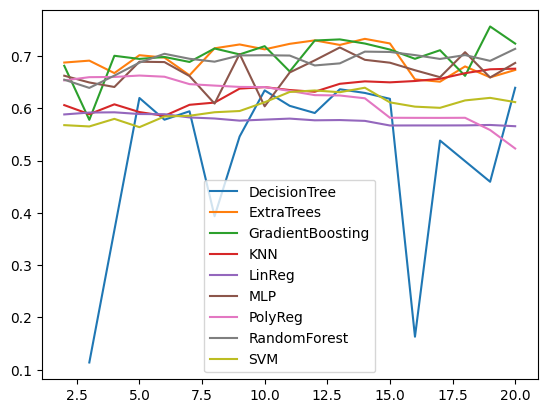

In [ ]:
fig, ax = plt.subplots()
for model in np.unique(order_progression.MODEL):
    #if model == 'DT': continue
    data_filt = order_progression[order_progression.MODEL == model]
    data_filt = data_filt[data_filt['R2 TEST FS'] >= 0]
    ax.plot(data_filt.ORDER, data_filt['R2 TEST FS'], label=model)
ax.legend()

In [ ]:
binary = os.path.join(os.getcwd(), 'outputs', 'test_runs', f'{prefix}_ml.pkl')
print(binary)

with open(binary, 'wb') as bin_file:
    pickle.dump((X1_tr, y_tr, X1_te, y_te, results, order_progression), bin_file)

/mnt/d/OneDrive/Mestrado/gits/sklearn-sid/Volve-Dataset/outputs/test_runs/MISO.W1_ml.pkl


In [ ]:
print(results['PARS'][-1])

{'activation': 'relu', 'alpha': 0.0014714861101156717, 'batch_size': 128, 'early_stopping': False, 'hidden_layer_sizes': (20, 40, 20, 40), 'max_iter': 10000, 'solver': 'adam', 'tol': 5.565552416696972e-06}
